In [13]:
# Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import random

# Import machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

In [14]:
# Load the dataset
old_train_data = pd.read_csv('data/3_old_train_processed.csv')
train_data = pd.read_csv('data/3_train_processed.csv')
train_ros_adta = pd.read_csv('data/3_train_ros_processed.csv')
train_smote_data = pd.read_csv('data/3_train_smote_processed.csv')

# Extract X and y
old_X = old_train_data.drop(['credit_score'], axis=1)
old_y = old_train_data['credit_score']
X = train_data.drop(['credit_score'], axis=1)
X_ros = train_ros_adta.drop(['credit_score'], axis=1)
X_smote = train_smote_data.drop(['credit_score'], axis=1)
y = train_data['credit_score']
y_ros = train_ros_adta['credit_score']
y_smote = train_smote_data['credit_score']

old_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88872 entries, 0 to 88871
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   month                        88872 non-null  int64  
 1   age                          88872 non-null  float64
 2   annual_income                88872 non-null  float64
 3   monthly_inhand_salary        88872 non-null  float64
 4   num_bank_accounts            88872 non-null  float64
 5   num_credit_card              88872 non-null  float64
 6   interest_rate                88872 non-null  float64
 7   num_of_loan                  88872 non-null  float64
 8   delay_from_due_date          88872 non-null  float64
 9   num_of_delayed_payment       88872 non-null  float64
 10  changed_credit_limit         88872 non-null  float64
 11  num_credit_inquiries         88872 non-null  float64
 12  credit_mix                   88872 non-null  int64  
 13  outstanding_debt

In [15]:
def train_and_find_best_model(model, model_name, X, y, metric='Macro F1'):
    print(f"Training {model_name} Model...")
    results = evaluate_model(model, X, y, model_name, best_metric=metric)
    best_model_name = results['Model Name']
    best_model = results['Best Model']
    best_score = results[f'Best {metric}']
    fold_results = results['Fold Results']
    # Drop model
    results_df = pd.DataFrame([results])
    results_df = results_df.drop(columns=['Best Model'])
    print(f"Best Model is {best_model_name}, {metric} = {best_score:.4f}")
    return best_model, best_model_name, results_df, fold_results

def evaluate_model(model, X, y, model_name, best_metric='Macro F1', n=5):
    current_run = 0
    cv = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    class_labels = sorted(np.unique(y))
    
    # Performance metrics
    accuracy_scores = []
    precision_macro_scores = []
    recall_macro_scores = []
    f1_macro_scores = []
    roc_auc_scores = []
    fold_results_list = []

    # Best model
    best_model = None
    best_score = -np.inf
    
    # Recall and Precision for each class
    per_class_precision = {cls: [] for cls in class_labels}
    per_class_recall = {cls: [] for cls in class_labels}
    
    for train_idx, test_idx in cv.split(X, y):
        print(f"Fold {current_run + 1}/{n}")
        current_run += 1
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Predict probabilities
        y_proba = model.predict_proba(X_test)
        
        # Calculate metrics
        accuracy_score_result = accuracy_score(y_test, y_pred)
        precision_macro_score_result = precision_score(y_test, y_pred, average='macro')
        recall_macro_score_result = recall_score(y_test, y_pred, average='macro')
        f1_macro_score_result = f1_score(y_test, y_pred, average='macro')
        roc_auc_score_result = roc_auc_score(y_test, y_proba, multi_class='ovr')
        
        accuracy_scores.append(accuracy_score_result)
        precision_macro_scores.append(precision_macro_score_result)
        recall_macro_scores.append(recall_macro_score_result)
        f1_macro_scores.append(f1_macro_score_result)
        roc_auc_scores.append(roc_auc_score_result)

        # Compare with the best model
        if best_model is None or f1_macro_score_result > best_score:
            best_model = model
            best_score = f1_macro_score_result
        
        # Calculate per-class precision and recall
        fold_class_metrics = {}
        for cls in class_labels:
            y_test_binary = (y_test == cls)
            y_pred_binary = (y_pred == cls)
            cls_precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
            cls_recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
            per_class_precision[cls].append(cls_precision)
            per_class_recall[cls].append(cls_recall)
            fold_class_metrics[f'Class {cls} Precision'] = cls_precision
            fold_class_metrics[f'Class {cls} Recall'] = cls_recall
        
        # Store fold results
        fold_result = {
            'Fold': current_run,
            'Model Name': model_name,
            'Accuracy': accuracy_score_result,
            'Macro Precision': precision_macro_score_result,
            'Macro Recall': recall_macro_score_result,
            'Macro F1': f1_macro_score_result,
            'ROC AUC': roc_auc_score_result,
        }
        fold_result.update(fold_class_metrics)
        fold_results_list.append(fold_result)
    
    # Final Results
    overall_results = {
        'Model Name': model_name,
        'Best Model': best_model,
        f'Best {best_metric}': best_score,
        'Accuracy': np.mean(accuracy_scores),
        'Macro Precision': np.mean(precision_macro_scores),
        'Macro Recall': np.mean(recall_macro_scores),
        'Macro F1': np.mean(f1_macro_scores),
        'ROC AUC': np.mean(roc_auc_scores),
        'Fold Results': fold_results_list  # 每个 fold 的详细结果
    }
    
    # 添加整体各类别的平均指标
    for cls in class_labels:
        overall_results[f'Class {cls} Precision'] = np.mean(per_class_precision[cls])
        overall_results[f'Class {cls} Recall'] = np.mean(per_class_recall[cls])
    
    return overall_results

def save_best_model(best_model, best_model_name, models_dir='models'):
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    # Create a filename for the model
    model_filename = f"{best_model_name.replace(' ', '_').lower()}.joblib"
    model_path = os.path.join(models_dir, model_filename)
    # Save the model
    joblib.dump(best_model, model_path)
    print(f"Best Model Saved: {model_path}")
    return model_path

In [16]:
def visualize_results(results_list):
    """Visualize evaluation results for different models"""
    results_df = pd.DataFrame(results_list).set_index('Model Name')
    
    # 1. Main metrics bar chart
    main_metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1', 'ROC AUC']
    plt.figure(figsize=(14, 7))
    plt.bar = results_df[main_metrics].plot(kind='bar')
    # results_df[main_metrics].plot(kind='bar')
    plt.title('Model Performance Comparison - Main Metrics')
    plt.ylabel('Score')
    # plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(main_metrics), frameon=True)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 2. Class-specific precision and recall
    class_metrics = [col for col in results_df.columns if 'Class' in col]
    if class_metrics:
        plt.figure(figsize=(14, 7))
        sns.heatmap(results_df[class_metrics], annot=True, cmap='YlGnBu', fmt='.3f')
        plt.title('Precision and Recall by Class')
        plt.tight_layout()
        plt.show()
    
    # 3. Comprehensive score
    results_df['Comprehensive Score'] = 0.5 * results_df['Macro F1'] + 0.5 * results_df['Accuracy']
    plt.figure(figsize=(10, 5))
    results_df['Comprehensive Score'].sort_values().plot(kind='barh', figsize=(10, 5))
    plt.title('Model Performance - Comprehensive Score')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return results_df

# 初始化模型
models = [
    (LogisticRegression(max_iter=10000, random_state=42), 'Logistic Regression'),
    (RandomForestClassifier(random_state=42), 'Random Forest'),
    (xgb.XGBClassifier(random_state=42), 'XGBoost')
]

In [17]:
# Seed
seed = 42
random.seed(seed)
np.random.seed(seed)

# Logistic Regression
logistic_model, logistic_model_name = LogisticRegression(max_iter=100000, random_state=42), 'Logistic Regression'
logistic_model, logistic_model_name, logistic_results_df, logistic_fold_results= train_and_find_best_model(logistic_model, logistic_model_name, X, y, metric='Macro F1')
logistic_model_path = save_best_model(logistic_model, logistic_model_name)
# ROS
logistic_model_ros, logistic_model_name_ros = LogisticRegression(max_iter=100000, random_state=42), 'Logistic Regression ROS'
logistic_model_ros, logistic_model_name_ros, logistic_results_ros_df, logistic_fold_results_ros = train_and_find_best_model(logistic_model_ros, logistic_model_name_ros, X_ros, y_ros, metric='Macro F1')
logistic_model_ros_path = save_best_model(logistic_model_ros, logistic_model_name_ros)
# SMOTE
logistic_model_smote, logistic_model_name_smote = LogisticRegression(max_iter=100000, random_state=42), 'Logistic Regression SMOTE'
logistic_model_smote, logistic_model_name_smote, logistic_results_smote_df, logistic_fold_results_smote = train_and_find_best_model(logistic_model_smote, logistic_model_name_smote, X_smote, y_smote, metric='Macro F1')
logistic_model_smote_path = save_best_model(logistic_model_smote, logistic_model_name_smote)


# Random Forest
rf_model, rf_model_name = RandomForestClassifier(random_state=42), 'Random Forest'
rf_model, rf_model_name, rf_results_df, rf_fold_results = train_and_find_best_model(rf_model, rf_model_name, X, y, metric='Macro F1')
rf_model_path = save_best_model(rf_model, rf_model_name)
# ROS
rf_model_ros, rf_model_name_ros = RandomForestClassifier(random_state=42), 'Random Forest ROS'
rf_model_ros, rf_model_name_ros, rf_results_ros_df, rf_fold_results_ros = train_and_find_best_model(rf_model_ros, rf_model_name_ros, X_ros, y_ros, metric='Macro F1')
rf_model_ros_path = save_best_model(rf_model_ros, rf_model_name_ros)
# SMOTE
rf_model_smote, rf_model_name_smote = RandomForestClassifier(random_state=42), 'Random Forest SMOTE'
rf_model_smote, rf_model_name_smote, rf_results_smote_df, rf_fold_results_smote = train_and_find_best_model(rf_model_smote, rf_model_name_smote, X_smote, y_smote, metric='Macro F1')
rf_model_smote_path = save_best_model(rf_model_smote, rf_model_name_smote)

# XGBoost
xgb_model, xgb_model_name = xgb.XGBClassifier(random_state=42), 'XGBoost'
xgb_model, xgb_model_name, xgb_results_df, xgb_fold_results = train_and_find_best_model(xgb_model, xgb_model_name, X, y, metric='Macro F1')
xgb_model_path = save_best_model(xgb_model, xgb_model_name)
# ROS
xgb_model_ros, xgb_model_name_ros = xgb.XGBClassifier(random_state=42), 'XGBoost ROS'
xgb_model_ros, xgb_model_name_ros, xgb_results_ros_df, xgb_fold_results_ros = train_and_find_best_model(xgb_model_ros, xgb_model_name_ros, X_ros, y_ros, metric='Macro F1')
xgb_model_ros_path = save_best_model(xgb_model_ros, xgb_model_name_ros)
# SMOTE
xgb_model_smote, xgb_model_name_smote = xgb.XGBClassifier(random_state=42), 'XGBoost SMOTE'
xgb_model_smote, xgb_model_name_smote, xgb_results_smote_df, xgb_fold_results_smote = train_and_find_best_model(xgb_model_smote, xgb_model_name_smote, X_smote, y_smote, metric='Macro F1')
xgb_model_smote_path = save_best_model(xgb_model_smote, xgb_model_name_smote)


# Combine results
logistic_results = pd.concat([logistic_results_df, logistic_results_ros_df, logistic_results_smote_df], axis=0)
rf_results = pd.concat([rf_results_df, rf_results_ros_df, rf_results_smote_df], axis=0)
xgb_results = pd.concat([xgb_results_df, xgb_results_ros_df, xgb_results_smote_df], axis=0)

# Combine results
original_results = pd.concat([logistic_results_df, rf_results_df, xgb_results_df], axis=0)
ros_results = pd.concat([logistic_results_ros_df, rf_results_ros_df, xgb_results_ros_df], axis=0)
smote_results = pd.concat([logistic_results_smote_df, rf_results_smote_df, xgb_results_smote_df], axis=0)

Training Logistic Regression Model...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Best Model is Logistic Regression, Macro F1 = 0.6317
Best Model Saved: models/logistic_regression.joblib
Training Logistic Regression ROS Model...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Best Model is Logistic Regression ROS, Macro F1 = 0.7018
Best Model Saved: models/logistic_regression_ros.joblib
Training Logistic Regression SMOTE Model...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Best Model is Logistic Regression SMOTE, Macro F1 = 0.7237
Best Model Saved: models/logistic_regression_smote.joblib
Training Random Forest Model...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Best Model is Random Forest, Macro F1 = 0.8084
Best Model Saved: models/random_forest.joblib
Training Random Forest ROS Model...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Best Model is Random Forest ROS, Macro F1 = 0.9106
Best Model Saved: models/random_forest_ros.joblib
Training Random Forest SMOTE Model...
Fold 1/5
Fold 2/

In [26]:
final_fold_results_df = pd.concat([pd.DataFrame(logistic_fold_results), pd.DataFrame(logistic_fold_results_ros), pd.DataFrame(logistic_fold_results_smote), pd.DataFrame(rf_fold_results), pd.DataFrame(rf_fold_results_ros), pd.DataFrame(rf_fold_results_smote), pd.DataFrame(xgb_fold_results), pd.DataFrame(xgb_fold_results_ros), pd.DataFrame(xgb_fold_results_smote)], axis=0)
# final_fold_results_df.to_csv('data/4_final_fold_results.csv', index=False)
final_fold_results_df

,Fold,Model Name,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall
0,1,Logistic Regression,0.656188,0.636743,0.631663,0.630089,0.813556,0.684241,0.537775,0.681942,0.736786,0.544047,0.620429
1,2,Logistic Regression,0.654219,0.633989,0.631809,0.630154,0.810149,0.665740,0.548535,0.682755,0.726883,0.553471,0.620008
2,3,Logistic Regression,0.658063,0.638786,0.631811,0.631687,0.813442,0.682997,0.542707,0.682340,0.739864,0.551020,0.612863
3,4,Logistic Regression,0.656657,0.637401,0.630989,0.630180,0.815688,0.674949,0.528738,0.682282,0.742540,0.554972,0.621690
4,5,Logistic Regression,0.649905,0.629709,0.627788,0.624831,0.809790,0.670893,0.533089,0.678795,0.726482,0.539440,0.623792
0,1,Logistic Regression ROS,0.698515,0.696682,0.698515,0.695504,0.827916,0.727698,0.686605,0.649287,0.584906,0.713062,0.824033
1,2,Logistic Regression ROS,0.700566,0.698204,0.700566,0.697366,0.826176,0.727324,0.693162,0.647753,0.580490,0.719535,0.828048
2,3,Logistic Regression ROS,0.695526,0.694199,0.695526,0.692593,0.825359,0.732762,0.675498,0.640902,0.585842,0.708932,0.825238
3,4,Logistic Regression ROS,0.704804,0.703546,0.704804,0.701771,0.831105,0.736304,0.694233,0.663213,0.591061,0.711121,0.829118
4,5,Logistic Regression ROS,0.696686,0.695080,0.696686,0.693669,0.824775,0.731252,0.686337,0.645713,0.581426,0.708276,0.822294


<Figure size 1400x700 with 0 Axes>

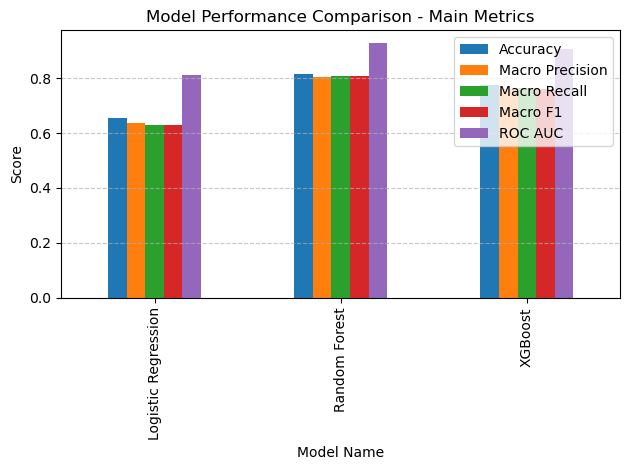

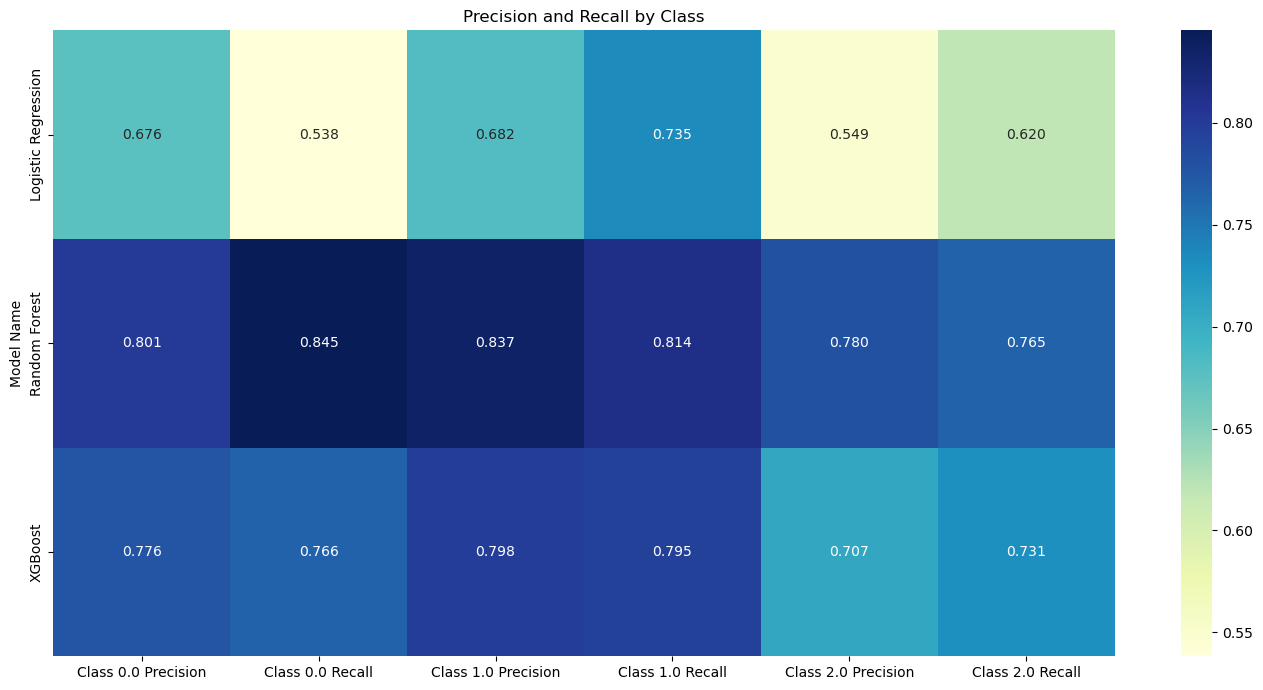

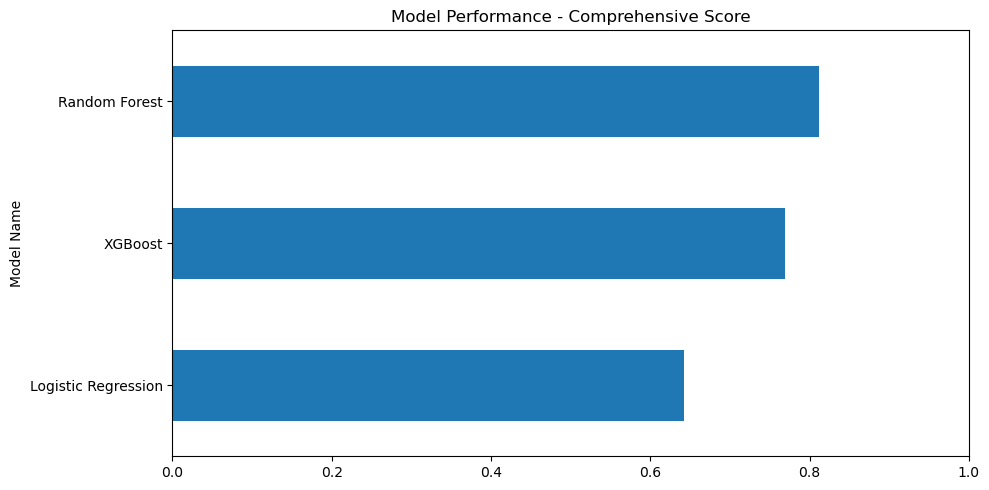


详细评估指标:


,Best Macro F1,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC,Fold Results,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall,Comprehensive Score
Model Name,,,,,,,,,,,,,,
Logistic Regression,0.631687,0.655007,0.635326,0.630812,0.629388,0.812525,"[{'Fold': 1, 'Model Name': 'Logistic Regressio...",0.675764,0.538169,0.681623,0.734511,0.548590,0.619756,0.642197
Random Forest,0.808396,0.815759,0.805869,0.808389,0.806849,0.928790,"[{'Fold': 1, 'Model Name': 'Random Forest', 'A...",0.801101,0.845492,0.836537,0.814479,0.779970,0.765195,0.811304
XGBoost,0.765384,0.775377,0.760191,0.764098,0.762049,0.908202,"[{'Fold': 1, 'Model Name': 'XGBoost', 'Accurac...",0.776181,0.766085,0.797656,0.794808,0.706737,0.731400,0.768713


In [19]:
# 可视化比较结果
old_results_df = visualize_results(original_results)

# 打印详细指标表格
print("\n详细评估指标:")
display(old_results_df)

<Figure size 1400x700 with 0 Axes>

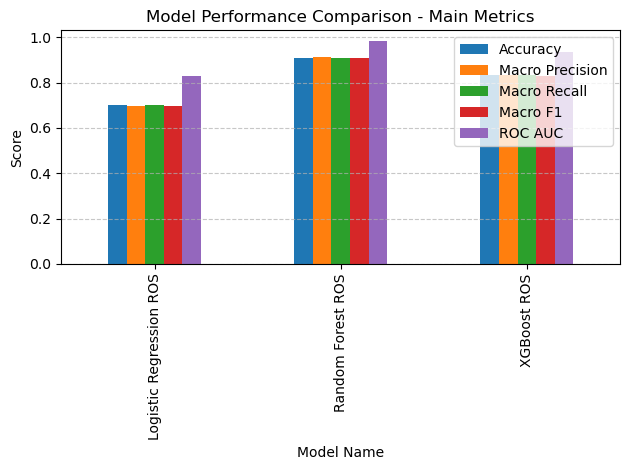

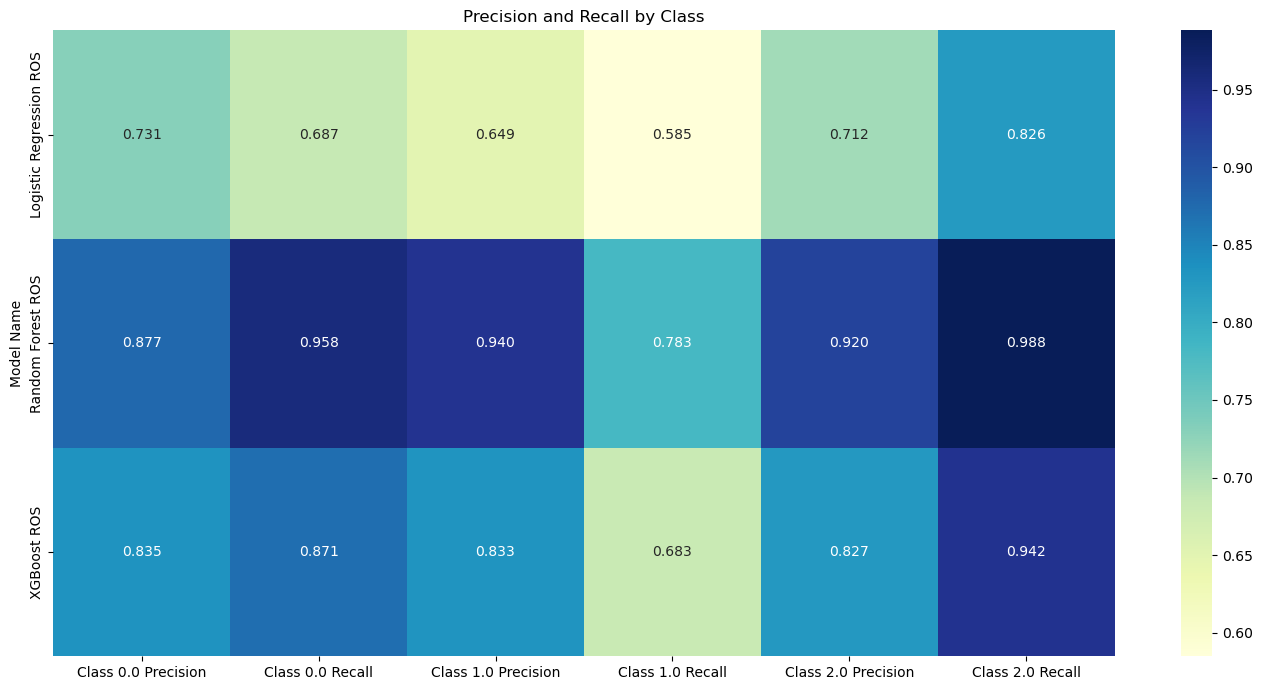

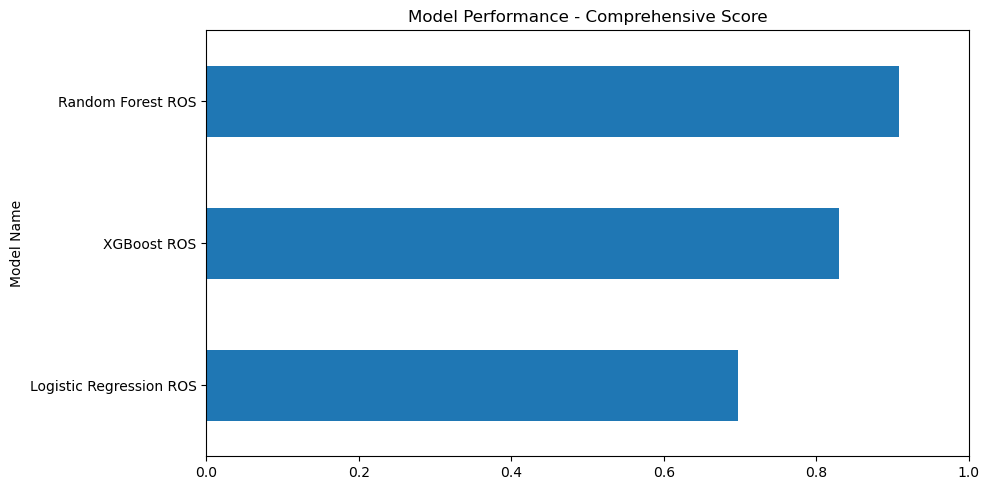


详细评估指标:


,Best Macro F1,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC,Fold Results,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall,Comprehensive Score
Model Name,,,,,,,,,,,,,,
Logistic Regression ROS,0.701771,0.699219,0.697542,0.699219,0.696181,0.827066,"[{'Fold': 1, 'Model Name': 'Logistic Regressio...",0.731068,0.687167,0.649373,0.584745,0.712185,0.825746,0.697700
Random Forest ROS,0.910555,0.909719,0.912131,0.909719,0.907558,0.981216,"[{'Fold': 1, 'Model Name': 'Random Forest ROS'...",0.877215,0.957527,0.939675,0.783300,0.919503,0.988331,0.908639
XGBoost ROS,0.830891,0.831634,0.831908,0.831634,0.827910,0.936614,"[{'Fold': 1, 'Model Name': 'XGBoost ROS', 'Acc...",0.835256,0.870574,0.833374,0.682671,0.827095,0.941657,0.829772


In [20]:
# 可视化比较结果
results_ros_df = visualize_results(ros_results)

# 打印详细指标表格
print("\n详细评估指标:")
display(results_ros_df)

<Figure size 1400x700 with 0 Axes>

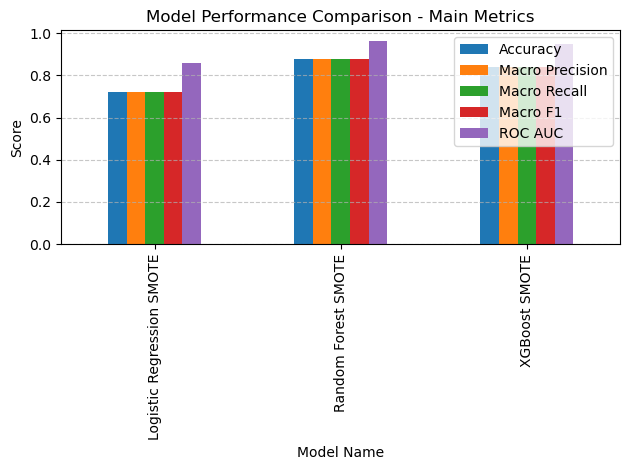

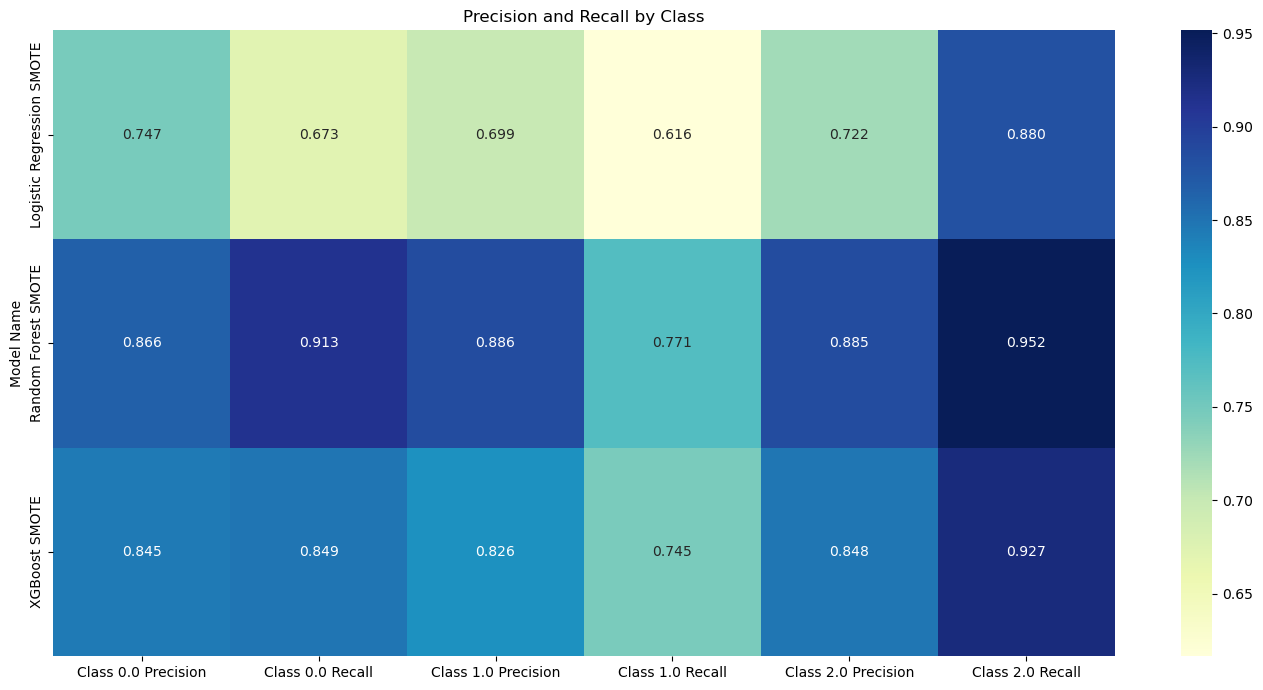

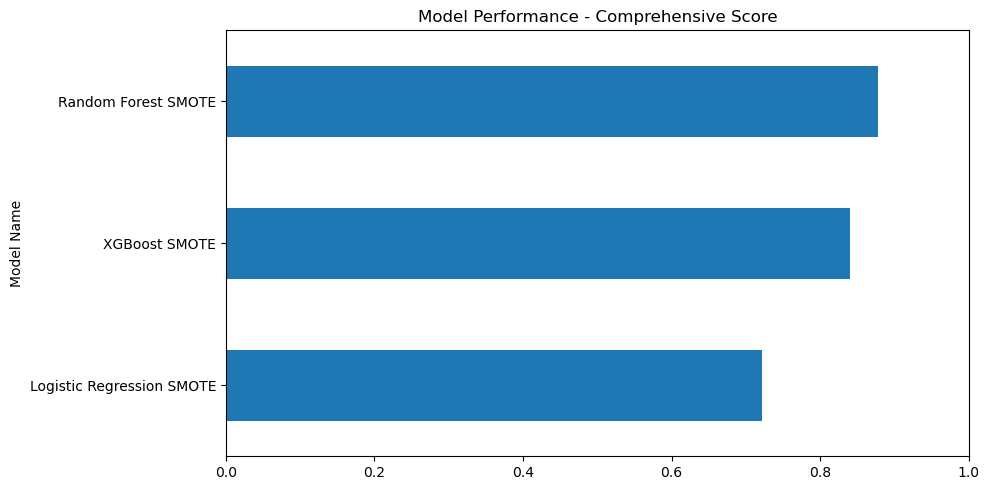


详细评估指标:


,Best Macro F1,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC,Fold Results,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall,Comprehensive Score
Model Name,,,,,,,,,,,,,,
Logistic Regression SMOTE,0.723673,0.723012,0.722924,0.723012,0.718858,0.858869,"[{'Fold': 1, 'Model Name': 'Logistic Regressio...",0.746830,0.672688,0.699497,0.616432,0.722445,0.879914,0.720935
Random Forest SMOTE,0.879342,0.878478,0.878876,0.878478,0.876734,0.964503,"[{'Fold': 1, 'Model Name': 'Random Forest SMOT...",0.865599,0.912833,0.885941,0.770989,0.885089,0.951612,0.877606
XGBoost SMOTE,0.840935,0.840234,0.839534,0.840234,0.838606,0.949965,"[{'Fold': 1, 'Model Name': 'XGBoost SMOTE', 'A...",0.845093,0.848896,0.825779,0.745216,0.847730,0.926589,0.839420


In [21]:
# 可视化比较结果
results_smote_df = visualize_results(smote_results)

# 打印详细指标表格
print("\n详细评估指标:")
display(results_smote_df)

In [22]:
# Load the test data
test_data = pd.read_csv('data/3_test_processed.csv')
feature = test_data.drop(['credit_score'], axis=1)
target = test_data['credit_score']

# Load the best model
logistic_model = joblib.load(logistic_model_path)
logistic_model_ros = joblib.load(logistic_model_ros_path)
logistic_model_smote = joblib.load(logistic_model_smote_path)
rf_model = joblib.load(rf_model_path)
rf_model_ros = joblib.load(rf_model_ros_path)
rf_model_smote = joblib.load(rf_model_smote_path)
xgb_model = joblib.load(xgb_model_path)
xgb_model_ros = joblib.load(xgb_model_ros_path)
xgb_model_smote = joblib.load(xgb_model_smote_path)

# Evaluate the models on the test data
def evaluate_model_on_test_data(model, X, y, model_name):
    """Evaluate the model on the test data and print the results"""
    results = []
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    roc_auc = roc_auc_score(y, model.predict_proba(X), multi_class='ovr')

    results.append({
        'Model Name': model_name,
        'Accuracy': accuracy,
        'Macro Precision': precision,
        'Macro Recall': recall,
        'Macro F1': f1,
        'ROC AUC': roc_auc
    })
    return pd.DataFrame(results)

# Evaluate the models on the test data
logistic_results_test = evaluate_model_on_test_data(logistic_model, feature, target, 'Logistic Regression')
logistic_results_ros_test = evaluate_model_on_test_data(logistic_model_ros, feature, target, 'Logistic Regression ROS')
logistic_results_smote_test = evaluate_model_on_test_data(logistic_model_smote, feature, target, 'Logistic Regression SMOTE')
rf_results_test = evaluate_model_on_test_data(rf_model, feature, target, 'Random Forest')
rf_results_ros_test = evaluate_model_on_test_data(rf_model_ros, feature, target, 'Random Forest ROS')
rf_results_smote_test = evaluate_model_on_test_data(rf_model_smote, feature, target, 'Random Forest SMOTE')
xgb_results_test = evaluate_model_on_test_data(xgb_model, feature, target, 'XGBoost')
xgb_results_ros_test = evaluate_model_on_test_data(xgb_model_ros, feature, target, 'XGBoost ROS')
xgb_results_smote_test = evaluate_model_on_test_data(xgb_model_smote, feature, target, 'XGBoost SMOTE')

# Combine test results
test_results = pd.concat([logistic_results_test, logistic_results_ros_test, logistic_results_smote_test,
                           rf_results_test, rf_results_ros_test, rf_results_smote_test,
                           xgb_results_test, xgb_results_ros_test, xgb_results_smote_test], axis=0)
test_results

,Model Name,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC
0,Logistic Regression,0.656484,0.637382,0.629064,0.629668,0.811395
0,Logistic Regression ROS,0.654402,0.635597,0.690389,0.645785,0.806476
0,Logistic Regression SMOTE,0.656428,0.634759,0.681204,0.644523,0.802521
0,Random Forest,0.811758,0.804603,0.803444,0.803575,0.925395
0,Random Forest ROS,0.782841,0.762045,0.794468,0.775403,0.914103
0,Random Forest SMOTE,0.726695,0.706106,0.766013,0.718723,0.889846
0,XGBoost,0.742672,0.724484,0.732063,0.727380,0.889981
0,XGBoost ROS,0.697215,0.675530,0.728343,0.689469,0.868013
0,XGBoost SMOTE,0.544248,0.630950,0.678493,0.536681,0.844831


In [23]:
test_results.to_csv('data/4_test_results.csv', index=False)

In [24]:
import pandas as pd
test_results = pd.read_csv('data/4_test_results.csv')

print(test_results)

                  Model Name  Accuracy  Macro Precision  Macro Recall  \
0        Logistic Regression  0.656484         0.637382      0.629064   
1    Logistic Regression ROS  0.654402         0.635597      0.690389   
2  Logistic Regression SMOTE  0.656428         0.634759      0.681204   
3              Random Forest  0.811758         0.804603      0.803444   
4          Random Forest ROS  0.782841         0.762045      0.794468   
5        Random Forest SMOTE  0.726695         0.706106      0.766013   
6                    XGBoost  0.742672         0.724484      0.732063   
7                XGBoost ROS  0.697215         0.675530      0.728343   
8              XGBoost SMOTE  0.544248         0.630950      0.678493   

   Macro F1   ROC AUC  
0  0.629668  0.811395  
1  0.645785  0.806476  
2  0.644523  0.802521  
3  0.803575  0.925395  
4  0.775403  0.914103  
5  0.718723  0.889846  
6  0.727380  0.889981  
7  0.689469  0.868013  
8  0.536681  0.844831  
